In [6]:
import numpy as np
from colour import Color
from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import gif

#CUSTOM CMAP
def customcmap(t_i, t_r):
    Scol = Color("#f5ebeb")
    Icol1 = Color("#5e0202")
    Icol2 = Color("#e81717")
    Rcol1 = Color("#e8c917")
    Rcol2 = Color("#e8db90")
    clist = [Scol] + list(Icol1.range_to(Icol2, t_i - 1)) + list(Rcol1.range_to(Rcol2, t_r))
    clist = [c.hex for c in clist]
    
    return colors.ListedColormap(clist)


#PROPOGATOR FUNCTION
def propogator(tau,x_dim,y_dim,t_i,t_r):
    #looping through all the blocks
    t=tau
    for i in np.arange(1,x_dim+1):
        for j in np.arange(1,y_dim+1):
            #for susceptible individuals (Using Moore Neighbourhood)
            if(t[i][j]==0):    
                count=0
                probability=0    
                if(1<=t[i-1][j]<=4):
                    count=count+1
                if(1<=t[i][j-1]<=4):
                    count=count+1
                if(1<=t[i+1][j]<=4):
                    count=count+1
                if(1<=t[i][j+1]<=4):
                    count=count+1
                if(1<=t[i-1][j-1]<=4):
                    count=count+1
                if(1<=t[i-1][j+1]<=4):
                    count=count+1
                if(1<=t[i+1][j+1]<=4):
                    count=count+1
                if(1<=t[i+1][j-1]<=4):
                    count=count+1

                probability=count/8
                x=np.random.random()
                if(x<=probability):
                    t[i][j]=1
                
            #for infected and refractory
            elif(1<=t[i][j]<t_i+t_r):
                t[i][j]=t[i][j]+1
                
            #last stage 
            elif(t[i][j]==t_i+t_r):
                t[i][j]=0
    #BOUNDARY CONDITIONS
    t[:,0]=t_r
    t[0,:]=t_r
    t[:,x_dim+1]=t_r
    t[y_dim+1,:]=t_r
    
    return t


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


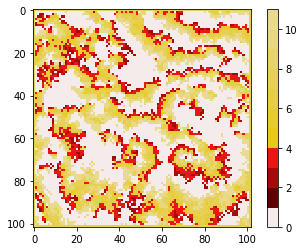

In [56]:
#MAIN PROGRAM
#parameters
t_i=4
t_r=7
x_dim=100
y_dim=100
time=100
cmap = customcmap(t_i, t_r)

#------INITIAL CONDITIONS-----------------#
#Distribution of Initial Population

p=0.001                                             #initial percentage of infected individuals 
tau_list=np.zeros(((x_dim + 2)*(y_dim + 2)), dtype=int)     
for k in range ((x_dim + 2)*(y_dim + 2)):
    rand=np.random.random()
    if(0<=rand<p):
        tau_list[k]=tau_list[k]+1
    elif(p<=rand<=1):
        tau_list[k]=tau_list[k]+0
    
tau=np.reshape(tau_list,(x_dim+2,y_dim+2))
tau[:,0]=t_r
tau[0,:]=t_r
tau[:,x_dim+1]=t_r
tau[y_dim+1,:]=t_r

#-------------------------------------------#
fig=plt.figure()
state=tau
plt.colorbar(plt.imshow(state, cmap=cmap, interpolation = 'nearest', vmin = 0, vmax = t_i+t_r))
ims=[] 
im=plt.imshow(state, animated=True, cmap = cmap, vmin = 0, vmax = t_i+t_r)
ims.append([im])
for t in range(time):
    state_new=propogator(state,x_dim,y_dim,t_i+t_r,t_r)
    state=state_new
    if(t%1==0):
        im=plt.imshow(state, animated=True, cmap = cmap, vmin = 0, vmax = t_i+t_r)
        ims.append([im])

ani=animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
ani.save('SIRSmodel.gif', writer='imagemagick', fps=5)
plt.show()